
# 🚀 AI + Kafka in Production (Colab-ready)

This notebook shows a **streaming, production-style pipeline** where:
- A **Producer** emits events (e.g., user messages) into a topic.
- An **AI Worker** consumes events and runs **NLP sentiment inference** using a Transformers model.
- A **Sink** consumes AI-enriched events for **analytics and monitoring**.
- It works in two modes:
  - `LOCAL_SIM` *(default)* — no external services required (uses in-memory queue to mimic Kafka).
  - `KAFKA` — connect to **Confluent Cloud** or any Kafka cluster via `confluent-kafka`.

> Switch modes in the **Configuration** cell below.


In [9]:

# @title Install dependencies (quietly)
# If using Colab, this is safe to run as-is.

!pip -q install confluent-kafka==2.4.0                   transformers==4.44.2       torch==2.8.0        faker==26.0.0                   pandas==2.2.2                   matplotlib==3.9.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.5 MB/s eta 0:00:00


In [2]:

# @title Configuration
from dataclasses import dataclass
from typing import Optional

# Choose mode: "LOCAL_SIM" (no Kafka needed) or "KAFKA" (requires credentials)
MODE = "LOCAL_SIM"  # @param ["LOCAL_SIM", "KAFKA"]

# Kafka config (only used when MODE == "KAFKA").
# For Confluent Cloud, set these from your cluster:
KAFKA_BOOTSTRAP = "YOUR_BOOTSTRAP_SERVER:9092"  # @param {type:"string"}
KAFKA_API_KEY = "YOUR_API_KEY"                  # @param {type:"string"}
KAFKA_API_SECRET = "YOUR_API_SECRET"            # @param {type:"string"}

INPUT_TOPIC  = "events.raw"     # @param {type:"string"}
OUTPUT_TOPIC = "events.scored"  # @param {type:"string"}

# Number of events to produce for the demo
N_EVENTS = 200  # @param {type:"integer"}

# Small sleep to throttle producer so demo is readable
PRODUCER_DELAY_SEC = 0.02  # @param {type:"number"}

# Batch size for AI worker consumption
WORKER_BATCH_SIZE = 8  # @param {type:"integer"}

# Path to write enriched results
RESULTS_CSV = "ai_kafka_results.csv"

@dataclass
class PipelineConfig:
    mode: str
    kafka_bootstrap: Optional[str] = None
    kafka_api_key: Optional[str] = None
    kafka_api_secret: Optional[str] = None
    input_topic: str = "events.raw"
    output_topic: str = "events.scored"
    n_events: int = 200
    producer_delay_sec: float = 0.02
    worker_batch_size: int = 8
    results_csv: str = "ai_kafka_results.csv"

CFG = PipelineConfig(
    mode=MODE,
    kafka_bootstrap=KAFKA_BOOTSTRAP,
    kafka_api_key=KAFKA_API_KEY,
    kafka_api_secret=KAFKA_API_SECRET,
    input_topic=INPUT_TOPIC,
    output_topic=OUTPUT_TOPIC,
    n_events=N_EVENTS,
    producer_delay_sec=PRODUCER_DELAY_SEC,
    worker_batch_size=WORKER_BATCH_SIZE,
    results_csv=RESULTS_CSV,
)

print("Config:", CFG)


Config: PipelineConfig(mode='LOCAL_SIM', kafka_bootstrap='YOUR_BOOTSTRAP_SERVER:9092', kafka_api_key='YOUR_API_KEY', kafka_api_secret='YOUR_API_SECRET', input_topic='events.raw', output_topic='events.scored', n_events=200, producer_delay_sec=0.02, worker_batch_size=8, results_csv='ai_kafka_results.csv')


In [3]:

# @title Utilities: logging, schemas, serialization
import json, time, uuid, random, threading, queue, os, sys, asyncio, logging
from datetime import datetime, timezone

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(name)s - %(message)s",
    datefmt="%H:%M:%S",
)
log = logging.getLogger("pipeline")

def utc_now_iso():
    return datetime.now(timezone.utc).isoformat()

def to_json(d: dict) -> bytes:
    return json.dumps(d, ensure_ascii=False).encode("utf-8")

def from_json(b: bytes) -> dict:
    return json.loads(b.decode("utf-8"))

# Simple event/message schemas
def make_event(user_id: str, text: str) -> dict:
    return {
        "event_id": str(uuid.uuid4()),
        "ts": utc_now_iso(),
        "user_id": user_id,
        "channel": random.choice(["web","mobile","api"]),
        "lang": random.choice(["en","hi","de"]),
        "text": text,
    }

def enrich_event(event: dict, sentiment: str, score: float) -> dict:
    ev = dict(event)
    ev.update({
        "ai_model": "distilbert-base-uncased-finetuned-sst-2-english",
        "sentiment": sentiment,
        "sentiment_score": float(score),
        "ai_ts": utc_now_iso(),
    })
    return ev


In [4]:

# @title LOCAL_SIM transport (drop-in replacement for Kafka)
class LocalQueue:
    def __init__(self):
        self.q = asyncio.Queue()

    async def produce(self, key: bytes, value: bytes):
        await self.q.put((key, value))

    async def consume_batch(self, max_n: int, timeout_s: float = 0.2):
        items = []
        try:
            item = await asyncio.wait_for(self.q.get(), timeout=timeout_s)
            items.append(item)
        except asyncio.TimeoutError:
            return items
        # drain up to max_n-1 more without waiting
        for _ in range(max_n - 1):
            try:
                item = self.q.get_nowait()
                items.append(item)
            except asyncio.QueueEmpty:
                break
        return items


In [10]:

# @title Kafka transport: Producer/Consumer helpers (only used in KAFKA mode)

from typing import List, Tuple

class KafkaTransport:
    def __init__(self, cfg):
        from confluent_kafka import Producer, Consumer, KafkaException, KafkaError, AdminClient, NewTopic
        self.cfg = cfg
        self.Producer = Producer
        self.Consumer = Consumer
        self.AdminClient = AdminClient
        self.NewTopic = NewTopic
        self.KafkaException = KafkaException
        self.KafkaError = KafkaError

        self.producer = self.Producer({
            "bootstrap.servers": cfg.kafka_bootstrap,
            "security.protocol": "SASL_SSL",
            "sasl.mechanisms": "PLAIN",
            "sasl.username": cfg.kafka_api_key,
            "sasl.password": cfg.kafka_api_secret,
            "linger.ms": 10,
            "batch.num.messages": 10000,
        })

        self.consumer = self.Consumer({
            "bootstrap.servers": cfg.kafka_bootstrap,
            "security.protocol": "SASL_SSL",
            "sasl.mechanisms": "PLAIN",
            "sasl.username": cfg.kafka_api_key,
            "sasl.password": cfg.kafka_api_secret,
            "group.id": "ai-worker-group",
            "auto.offset.reset": "earliest",
            "enable.auto.commit": False,
        })

        self.sink_consumer = self.Consumer({
            "bootstrap.servers": cfg.kafka_bootstrap,
            "security.protocol": "SASL_SSL",
            "sasl.mechanisms": "PLAIN",
            "sasl.username": cfg.kafka_api_key,
            "sasl.password": cfg.kafka_api_secret,
            "group.id": "sink-group",
            "auto.offset.reset": "earliest",
            "enable.auto.commit": True,
        })

    def create_topics(self):
        admin = self.AdminClient({
            "bootstrap.servers": self.cfg.kafka_bootstrap,
            "security.protocol": "SASL_SSL",
            "sasl.mechanisms": "PLAIN",
            "sasl.username": self.cfg.kafka_api_key,
            "sasl.password": self.cfg.kafka_api_secret,
        })
        topics = [self.NewTopic(self.cfg.input_topic, num_partitions=3, replication_factor=3),
                  self.NewTopic(self.cfg.output_topic, num_partitions=3, replication_factor=3)]
        fs = admin.create_topics(topics, request_timeout=30)
        for t, f in fs.items():
            try:
                f.result()
                log.info(f"Created topic: {t}")
            except Exception as e:
                log.info(f"Topic create for {t} returned: {e} (this is OK if it already exists)")

    async def produce(self, topic: str, key: bytes, value: bytes):
        # confluent-kafka is sync; wrap in thread executor using asyncio.to_thread
        def _produce():
            self.producer.produce(topic=topic, key=key, value=value)
            self.producer.poll(0)
        await asyncio.to_thread(_produce)

    async def consume_batch(self, topic: str, max_n: int, timeout_s: float = 0.5) -> List[Tuple[bytes, bytes]]:
        self.consumer.subscribe([topic])
        msgs = []
        end = time.time() + timeout_s
        while len(msgs) < max_n and time.time() < end:
            msg = self.consumer.poll(0.05)
            if msg is None:
                await asyncio.sleep(0.01)
                continue
            if msg.error():
                if msg.error().code() == self.KafkaError._PARTITION_EOF:
                    continue
                else:
                    raise self.KafkaException(msg.error())
            msgs.append((msg.key(), msg.value()))
        if msgs:
            self.consumer.commit(asynchronous=False)
        return msgs

    def sink_subscribe(self, topic: str):
        self.sink_consumer.subscribe([topic])

    def sink_poll(self, timeout_s: float = 0.2):
        return self.sink_consumer.poll(timeout_s)


In [6]:

# @title AI Model: Sentiment pipeline
from transformers import pipeline

nlp = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def run_inference(texts):
    # Returns list of dicts with 'label' and 'score'
    return nlp(texts, truncation=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [11]:

# @title Producer: generate synthetic user messages
from faker import Faker
fake = Faker()

SAMPLE_TEXTS = [
    "This app is fantastic! Super fast and easy to use.",
    "Terrible experience. Crashes every time I try to login.",
    "I love the new UI, great job team.",
    "Not satisfied with the support response times.",
    "Absolutely wonderful service. Highly recommended.",
    "The latest update broke notifications for me.",
    "Works as expected. No issues so far.",
    "Please fix the payment gateway, it's failing.",
    "Brilliant! Exactly what I needed.",
    "I'm frustrated. Why is it so slow today?",
]

async def producer_loop(cfg: PipelineConfig, transport):
    log.info(f"[PRODUCER] Starting in mode={cfg.mode}")
    for i in range(cfg.n_events):
        event = make_event(
            user_id=str(fake.pyint(min_value=1, max_value=50)),
            text=random.choice(SAMPLE_TEXTS),
        )
        key = event["user_id"].encode("utf-8")
        value = to_json(event)

        if cfg.mode == "KAFKA":
            await transport.produce(cfg.input_topic, key, value)
        else:
            await transport.produce(key, value)

        if (i + 1) % 50 == 0:
            log.info(f"[PRODUCER] Sent {i+1}/{cfg.n_events} events")
        await asyncio.sleep(cfg.producer_delay_sec)
    log.info("[PRODUCER] Done.")


In [12]:

# @title AI Worker: consume -> score -> produce
import itertools

async def worker_loop(cfg: PipelineConfig, transport_in, transport_out):
    log.info(f"[WORKER] Starting (batch_size={cfg.worker_batch_size})")
    total = 0
    while True:
        batch = await (transport_in.consume_batch(cfg.worker_batch_size, timeout_s=0.5) if cfg.mode != "KAFKA"
                       else transport_in.consume_batch(cfg.input_topic, cfg.worker_batch_size, timeout_s=0.5))
        if not batch:
            # Stop once producer likely finished and queue is empty (LOCAL_SIM heuristic)
            if cfg.mode == "LOCAL_SIM" and total >= cfg.n_events:
                break
            await asyncio.sleep(0.05)
            continue

        texts = [from_json(v)["text"] for _, v in batch]
        preds = run_inference(texts)
        for (k, v), pred in zip(batch, preds):
            base = from_json(v)
            enriched = enrich_event(base, sentiment=pred["label"], score=float(pred["score"]))
            key = k
            val = to_json(enriched)
            if cfg.mode == "KAFKA":
                await transport_out.produce(cfg.output_topic, key, val)
            else:
                await transport_out.produce(key, val)

        total += len(batch)
        if total % 40 == 0:
            log.info(f"[WORKER] Scored {total} events")
    log.info("[WORKER] Done.")


In [13]:

# @title Sink: consume enriched events for analytics
import pandas as pd
import matplotlib.pyplot as plt

async def sink_loop(cfg: PipelineConfig, transport):
    log.info("[SINK] Starting analytics sink")
    rows = []
    started = time.time()
    last_plot = 0.0

    if cfg.mode == "KAFKA":
        transport.sink_subscribe(cfg.output_topic)

    while True:
        if cfg.mode == "KAFKA":
            msg = transport.sink_poll(timeout_s=0.2)
            if msg is None:
                await asyncio.sleep(0.05)
                continue
            if msg.error():
                continue
            rec = from_json(msg.value())
        else:
            batch = await transport.consume_batch(50, timeout_s=0.2)
            if not batch:
                # Heuristic to end once worker likely drained
                if time.time() - started > 5:
                    break
                await asyncio.sleep(0.05)
                continue
            for _, v in batch:
                rows.append(from_json(v))
            # fall through to plotting/printing

        if cfg.mode == "KAFKA":
            rows.append(rec)

        # Periodically show live KPIs
        now = time.time()
        if now - last_plot > 2.5 and rows:
            last_plot = now
            df = pd.DataFrame(rows)
            # Live prints
            pos = (df["sentiment"] == "POSITIVE").sum()
            neg = (df["sentiment"] == "NEGATIVE").sum()
            log.info(f"[SINK] Records={len(df)} | POS={pos} NEG={neg} | Mean score={df['sentiment_score'].mean():.3f}")
            # Save CSV snapshot
            df.to_csv(CFG.results_csv, index=False)
            # Simple live chart
            counts = df["sentiment"].value_counts()
            plt.figure()
            counts.plot(kind="bar")  # No colors set per instructions
            plt.title("Sentiment Count (live)")
            plt.xlabel("Label")
            plt.ylabel("Count")
            plt.show()

        # Stop criteria for LOCAL_SIM: after a short cool-down
        if cfg.mode == "LOCAL_SIM" and len(rows) >= cfg.n_events:
            await asyncio.sleep(1.0)
            break

    # Final write
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv(CFG.results_csv, index=False)
        log.info(f"[SINK] Wrote {CFG.results_csv} with {len(df)} rows.")
    log.info("[SINK] Done.")


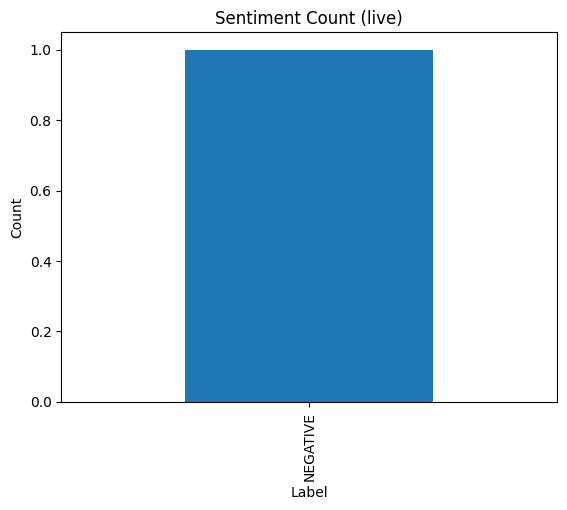

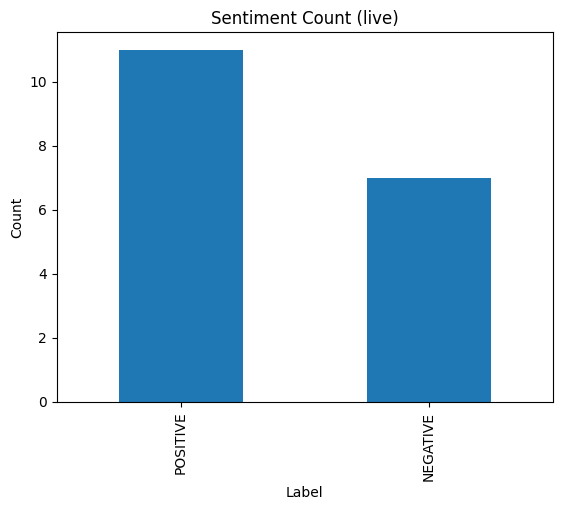

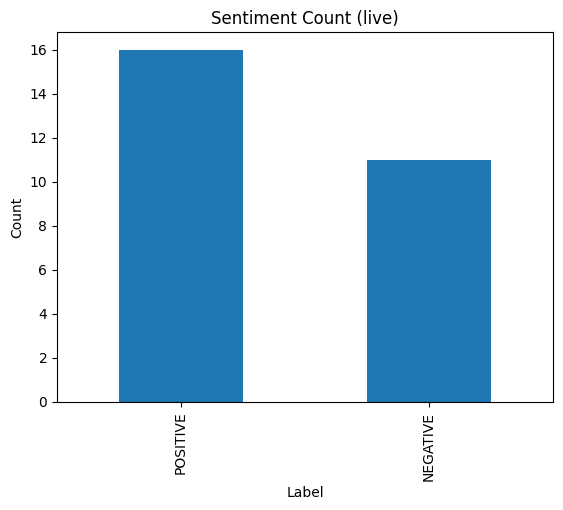

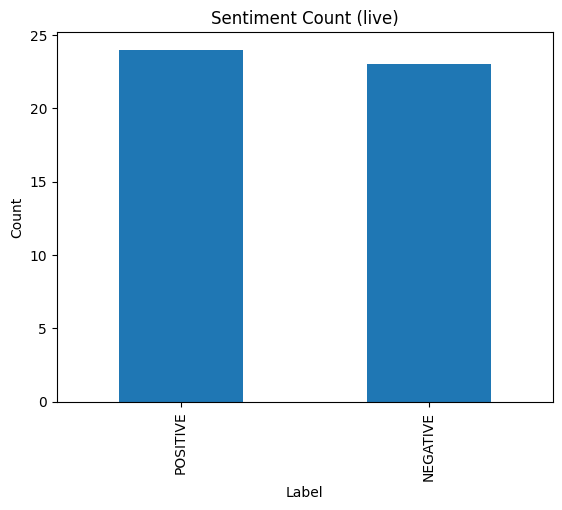

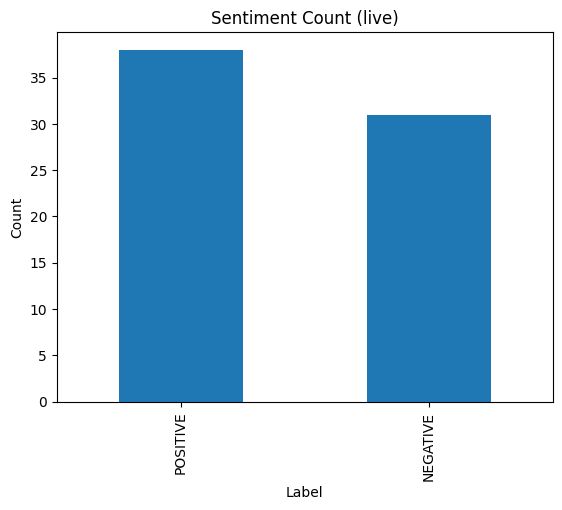

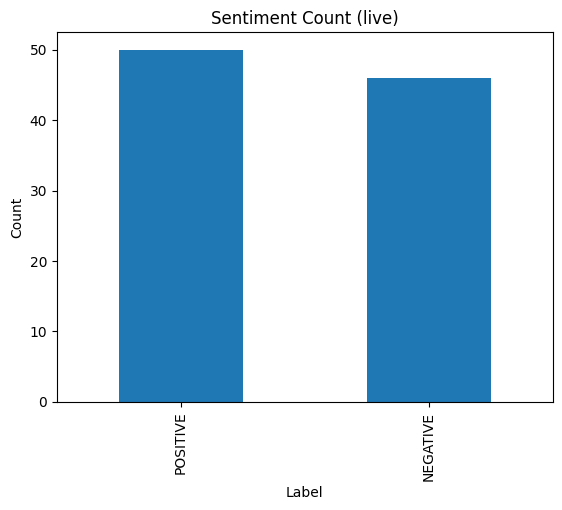

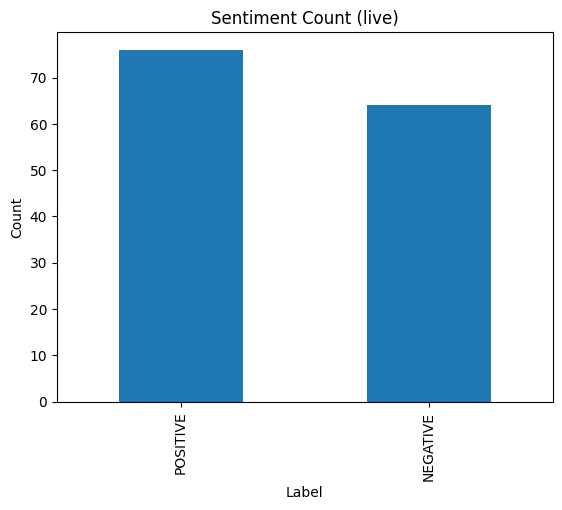

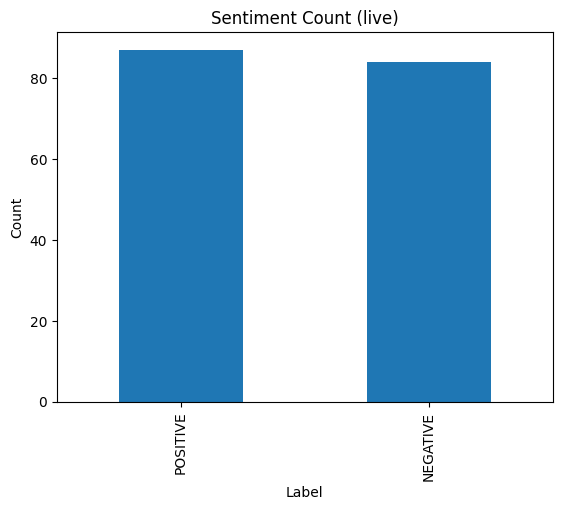

In [14]:

# @title Orchestrate the pipeline
async def main(cfg: PipelineConfig):
    if cfg.mode == "KAFKA":
        # Initialize Kafka transport and create topics
        kafka = KafkaTransport(cfg)
        kafka.create_topics()
        producer_transport = kafka
        worker_in = kafka
        worker_out = kafka
        sink_transport = kafka
    else:
        # LOCAL_SIM: two queues emulate two topics
        in_q = LocalQueue()
        out_q = LocalQueue()
        producer_transport = in_q
        worker_in = in_q
        worker_out = out_q
        sink_transport = out_q

    # Launch tasks
    tasks = []
    tasks.append(asyncio.create_task(producer_loop(cfg, producer_transport)))
    tasks.append(asyncio.create_task(worker_loop(cfg, worker_in, worker_out)))
    tasks.append(asyncio.create_task(sink_loop(cfg, sink_transport)))

    await asyncio.gather(*tasks)

# Kick it off
import nest_asyncio, asyncio
nest_asyncio.apply()
await main(CFG)



## 🧰 Production Notes & Hardening Ideas

- **Observability**: push metrics to Prometheus; add tracing with OpenTelemetry.
- **Backpressure**: tune Kafka `max.poll.interval.ms`, `max.in.flight.requests.per.connection`, and batching/linger for throughput.
- **Exactly-once / Idempotency**: use message keys and upsert-sinks (e.g., Kafka Streams or Flink with upsert-kafka).
- **Schema Management**: use Avro/Protobuf + Schema Registry to evolve safely.
- **Model Ops**: package the AI worker in Docker, add health/readiness endpoints, A/B models via topic multiplexing.
- **Scaling**: increase partitions; run multiple workers in the same consumer group for parallelism.
- **Security**: rotate API keys, least-privilege service accounts, network ACLs.
